# Australian Geoscience Datacube API
Perform band maths and produce a Normalised Difference Vegetation Index (NDVI) file.

In [1]:
from pprint import pprint
%matplotlib inline

import datacube.api

In [2]:
dc = datacube.api.API()

In [3]:
nbar = dc.get_dataset(product='NBAR', platform='LANDSAT_5', 
                      latitude=(-34.95,-35.05), longitude=(148.95,149.05), 
                      variables=['band_30', 'band_40'])

We are working on a semantics layer to be able to use alias for band names, but for now, we have to rely on the knowledge that band_30 is red, and band_40 is near-infrared.

In [4]:
red = nbar.band_30
nir = nbar.band_40

We can select the first time index and plot the first timeslice.

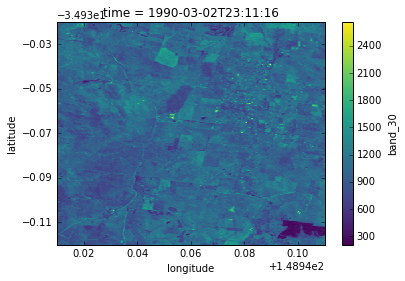

In [5]:
red.isel(time=0).plot()

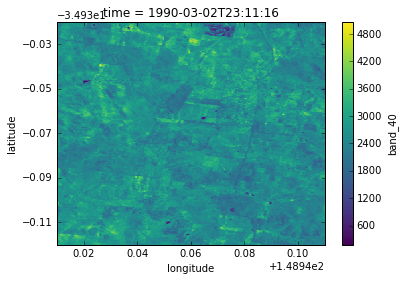

In [6]:
nir.isel(time=0).plot()

NDVI compares the red and near-infrared bands:

In [7]:
ndvi = (nir - red) / (nir + red)
ndvi.name = 'Normalised Difference Vegetation Index'

The `ndvi` array has values across the spatial and time dimensions.

In [8]:
ndvi

<xarray.DataArray 'Normalised Difference Vegetation Index' (time: 4, latitude: 400, longitude: 400)>
dask.array<elemwis..., shape=(4, 400, 400), dtype=float64, chunksize=(1, 200, 200)>
Coordinates:
  * time       (time) datetime64[ns] 1990-03-02T23:11:16 1990-05-05T23:10:28 ...
  * latitude   (latitude) float64 -34.95 -34.95 -34.95 -34.95 -34.95 -34.95 ...
  * longitude  (longitude) float64 149.0 149.0 149.0 149.0 149.0 149.0 149.0 ...

We can select the individual time layers to save out as an image, or make a labelled plot of it:

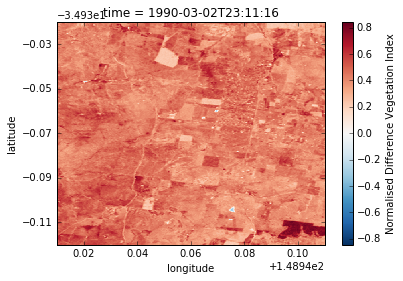

In [9]:
ndvi.isel(time=0).plot()

import matplotlib.image
matplotlib.image.imsave('ndvi.png', ndvi.isel(time=0))

We have set up the calculation of NDVI to happen for all timeslices. It will be computed when the data is requested, either explicitly by calling `ndvi.load()`, or by a function that accesses the data, such as plotting:
(This can take a while...)

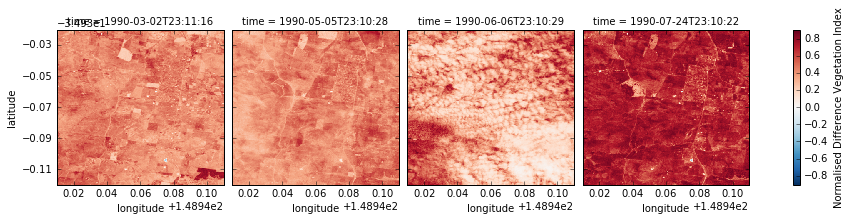

In [10]:
ndvi.plot(col='time')

The xarray can be turned into a Dataset, which can then be saved across all of the timeseries to a NetCDF file.

In [11]:
ds_ndvi = ndvi.to_dataset(name='ndvi')
ds_ndvi.to_netcdf('ndvi.nc')

## Behind the scenes

The ndvi result is performed by chaining a series of operations together on a per-chunk basis. The execution tree, including the masking on the `nodata` value done by the API, ends up being the same for each chunk. 

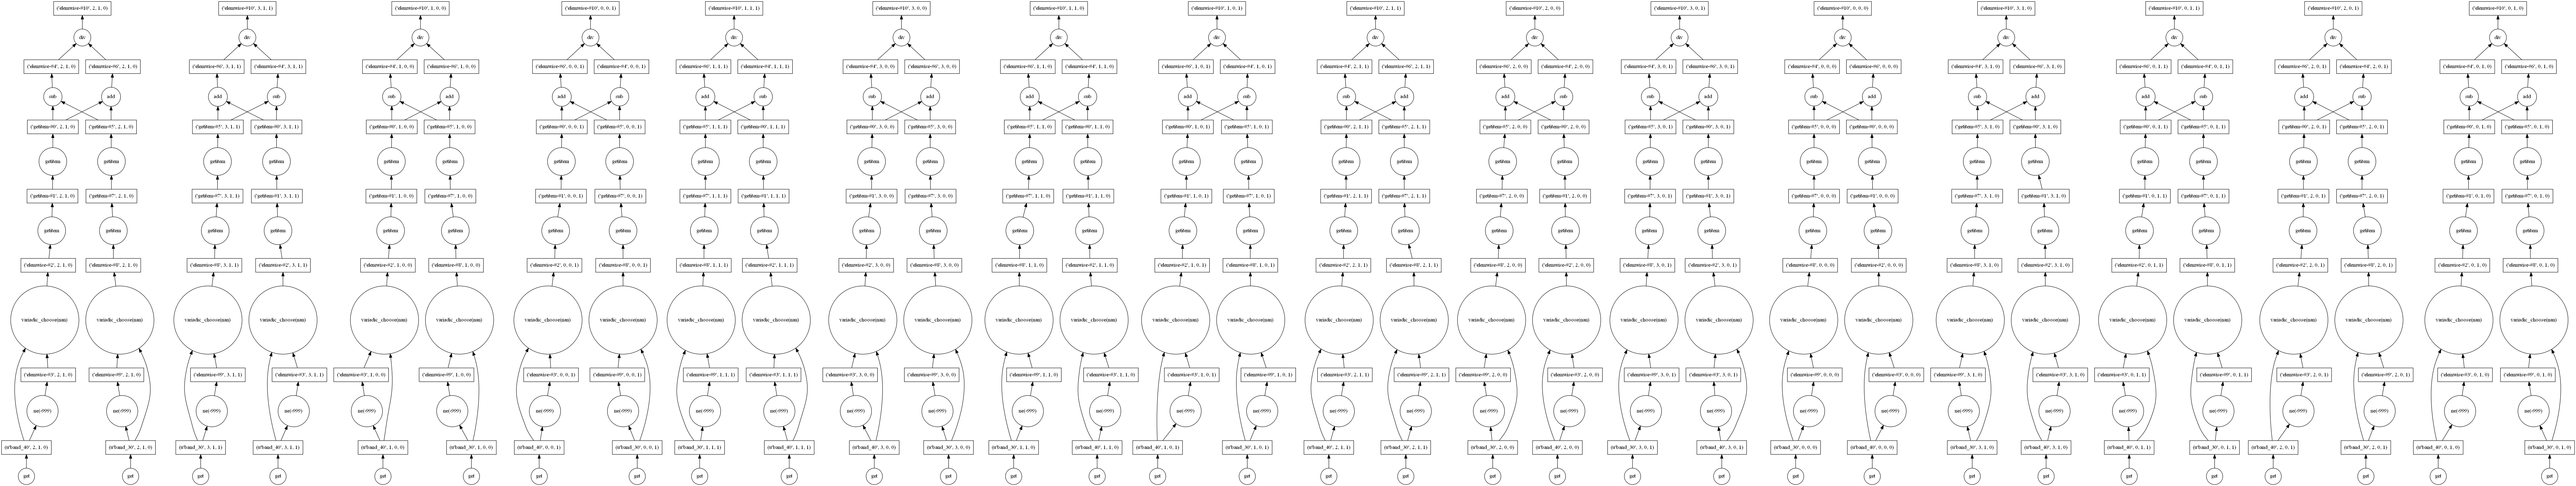

In [12]:
ndvi.data.visualize()

If we look at a single chunk, the NDVI calculation can be seen where the lines cross over to the `add` and `sub` circles.
Some optimizarion has taken place: the `div` operation has been combined with another inline function, and the other chunks have been discarded.

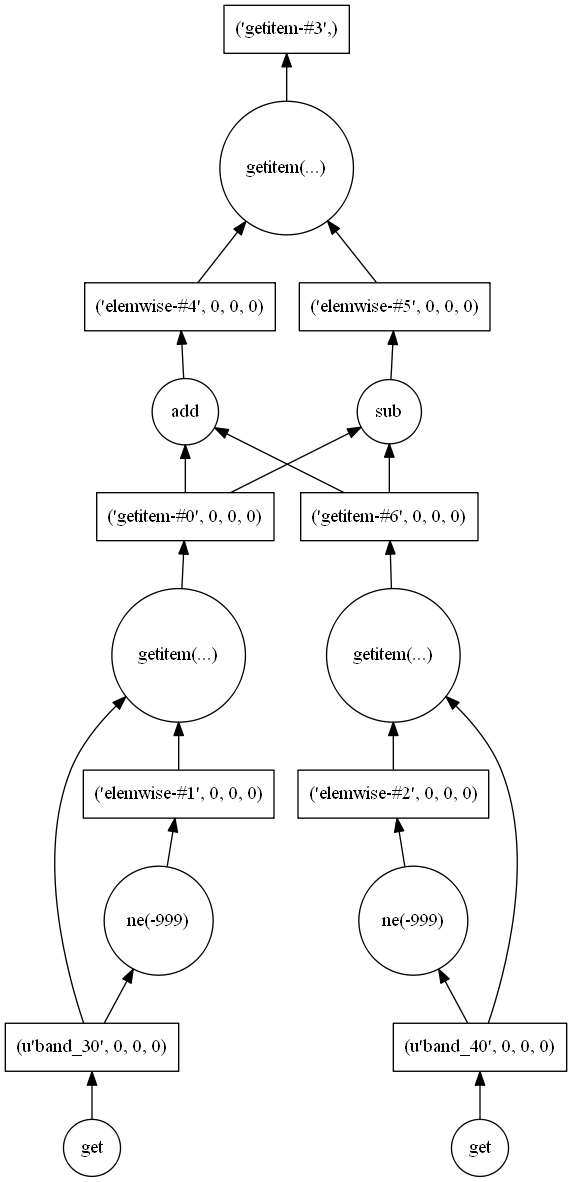

In [19]:
partial = ndvi[0,0,0]
partial.data.visualize(optimize_graph=True)